### Assignment Description

The dataset you will work with for this assignment is a collection of utterances extracted recorded in a controlled environment. This dataset is rich and diverse, featuring utterances from multiple speakers.

Here are the key characteristics of the dataset:
- Utterances: The dataset comprises various utterances from different actors. The sampling
rate of the audios is 44100.
- Emotional valence: Each utterance in the dataset has annotations for emotional valence,
a float number between 1 and 5.

Your goal is to build a Deep Learning model that is capable of estimating the emotional valence of a recording. Understanding your dataset is the first step towards building a successful model. So, take your time to explore and understand the data.

### Model Training

In [1]:
# Importing required and used modules

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Define paths
smalltrain_path = '/Users/sofie/Downloads/1000-data/' 
train_path = '/Users/sofie/Downloads/train/' 
test_path = '/Users/sofie/Downloads/test/' 

In [60]:
# def load_files(dir):
#     data = []
#     for file in os.listdir(dir):
#         if file.endswith('.pkl'):
#             with open(os.path.join(dir, file), 'rb') as f:
#                 data.append(pickle.load(f))
# 
#     return data
# 
# def extract_features(df, sr=8000):
#     feature_vectors = []
# 
#     for utterance in df:
#         y = utterance['audio_data']
# 
#         # MFCCs
#         mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#         mfcc_mean = np.mean(mfccs.T, axis=0)
#         mfcc_delta = librosa.feature.delta(mfccs)
#         mfcc_delta_mean = np.mean(mfcc_delta.T, axis=0)
#         mfcc_delta_square = librosa.feature.delta(mfccs, order=2)
#         mfcc_delta_square_mean = np.mean(mfcc_delta_square.T, axis=0)
# 
#         # Spectrogram (Mel-scaled)
#         spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
#         log_spec = librosa.power_to_db(spec, ref=np.max)
#         log_spec_mean = np.mean(log_spec.T, axis=0)
# 
#         # Zero Crossing Rate
#         zcr = librosa.feature.zero_crossing_rate(y)
#         zcr_mean = np.mean(zcr)
# 
#         # Combine all features into a single feature vector
#         feature_vector = np.concatenate((mfcc_mean, mfcc_delta_mean, mfcc_delta_square_mean, log_spec_mean, [zcr_mean]))
#         feature_vectors.append(feature_vector)
# 
#     return feature_vectors
# 
# def extract_labels(df):
#     labels = []
#     for utterance in df:
#         labels.append(utterance['valence'])
#     
#     return labels
# 
# class AudioDataset(Dataset):
#     def __init__(self, data):
#         self.data = data
#         self.features = extract_features(data)
#         self.labels = extract_labels(data)
# 
#     def __len__(self):
#         return len(self.data)
#      
#     def __getitem__(self, idx):
#         return self.features[idx], self.labels[idx]

In [65]:
# data = load_files(train_path)
# train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)
# 
# train_dataset = AudioDataset(train_data)
# val_dataset = AudioDataset(val_data)

In [68]:
# # Function for model evaluation
# def evaluate_model(model, criterion, dataloader):
#     model.eval()
#     total_loss = 0
#     count = 0
#     with torch.no_grad():  
#         for inputs, labels in dataloader:
#             inputs = inputs.float()
#             labels = labels.float()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels.view(-1, 1)) 
#             total_loss += loss.item()
#             count += 1
#     average_loss = total_loss / count
#     return average_loss

In [74]:
# # Defining early stopping class, used in tuning
# class EarlyStopping:
#     def __init__(self, patience=5, min_delta=0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False
# 
#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss < self.best_loss - self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
        
# class FCLayer(nn.Module):
#     def __init__(self, input_size, output_size, batch_norm=True, dropout=False):
#         super(FCLayer, self).__init__()
#         self.fc = nn.Linear(input_size, output_size)
#         self.bn = nn.BatchNorm1d(output_size) if batch_norm else None
#         self.dropout = nn.Dropout(0.5) if dropout else None
# 
#     def forward(self, x):
#         x = self.fc(x)
#         if self.bn:
#             x = self.bn(x)
#         if self.dropout:
#             x = self.dropout(x)
#         return x
# 
# class ConvLayer(nn.Module):
#     def __init__(self, input_size, output_size, kernel_size=3, padding=1, stride=2, batch_norm=True):
#         super(ConvLayer, self).__init__()
#         self.batch_norm = batch_norm
#         self.conv = nn.Conv1d(input_size, output_size, kernel_size, padding=padding, stride=stride)
#         self.bn = nn.BatchNorm1d(output_size) if batch_norm else None
#         self.pool = nn.MaxPool1d(kernel_size, stride)
# 
#     def forward(self, x):
#         x = self.conv(x)
#         if self.batch_norm:
#             x = self.bn(x)
#         x = F.relu(x)
#         x = self.pool(x)
#         return x
#     
# best_val_loss = float('inf')
# class CNN(nn.Module):
#     def __init__(self, input_size):
#         super(CNN, self).__init__()
#         self.convlayer1 = ConvLayer(1, 16)
#         self.convlayer2 = ConvLayer(16, 64)
# 
#         # Calculate the size of the flattened layer after convolutions
#         conv_output_size = self._get_conv_output_size(input_size)
# 
#         self.fclayer3 = FCLayer(conv_output_size, 512)
#         self.fclayer4 = FCLayer(512, 256)
#         self.fclayer5 = FCLayer(256, 128)
#         self.fclayer6 = FCLayer(128, 64)
#         self.fclayer7 = FCLayer(64, 32)
#         self.fclayer8 = FCLayer(32, 1, batch_norm=False, dropout=True)
# 
#     def _get_conv_output_size(self, input_size):
#         # Create a dummy tensor with the same shape as the input data
#         x = torch.zeros(1, 1, input_size)
#         x = self.convlayer1(x)
#         x = self.convlayer2(x)
#         return int(np.prod(x.size()))
# 
#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension for convolution
#         x = self.convlayer1(x)
#         x = self.convlayer2(x)
#         x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
#         
#         x = self.fclayer3(x)
#         x = self.fclayer4(x)
#         x = self.fclayer5(x)
#         x = self.fclayer6(x)
#         x = self.fclayer7(x)
#         x = self.fclayer8(x)
# 
#         return x
    
# Defining training and evaluation function
# def train_and_evaluate(lr: float, 
#                        batch_size: int, 
#                        num_epochs=10, 
#                        criterion=nn.MSELoss(), 
#                        tds: AudioDataset=train_dataset, 
#                        vds: AudioDataset=val_dataset, 
#                        accumulation_steps=4):
#     # Load the datasets
#     train_dataloader = DataLoader(tds, batch_size=int(batch_size), shuffle=True, num_workers=4)
#     val_dataloader = DataLoader(vds, batch_size=int(batch_size), shuffle=False, num_workers=4)
# 
#     # Initialise the CNN model, its optimisers and the scheduler
#     input_size = np.array(tds.features).shape[1]
#     model = CNN(input_size=input_size)
#     optimiser = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=2, factor=0.5, min_lr=0.0001)
# 
#     best_val_loss = float('inf')
#     early_stopping = EarlyStopping(patience=5, min_delta=0.001)
# 
#     for epoch in range(num_epochs):
#         model.train()
#         optimiser.zero_grad()
#         for i, (inputs, labels) in enumerate(train_dataloader):
#             inputs = inputs.float()
#             labels = labels.float()
#             
#             outputs = model(inputs)
#             loss = criterion(outputs, labels.view(-1, 1))
#             loss.backward()
#             
#             if (i + 1) % accumulation_steps == 0:
#                 optimiser.step()
#                 optimiser.zero_grad()
# 
#         validation_loss = evaluate_model(model, criterion, val_dataloader)
#         scheduler.step(validation_loss)
# 
#         if validation_loss < best_val_loss:
#             best_val_loss = validation_loss
#             torch.save(model.state_dict(), 'best_model.pth')
# 
#         early_stopping(validation_loss)
#         if early_stopping.early_stop:
#             print(f"Early stopping at epoch {epoch}")
#             break
# 
#     return best_val_loss, best_val_loss



# # Bayesian optimization for hyperparameter tuning
# def tune_hyperparameters():
#     def objective(learning_rate, batch_size):
#         target, mse = train_and_evaluate(lr=learning_rate, batch_size=batch_size)
#         print(f"Target: {target}, MSE: {mse}")
#         return target
# 
#     pbounds = {'learning_rate': (0.0001, 0.005), 'batch_size': (16, 128)}
# 
#     optimizer = BayesianOptimization(
#         f=objective,
#         pbounds=pbounds,
#         random_state=1,
#     )
# 
#     optimizer.maximize(
#         init_points=2,
#         n_iter=5, 
#     )
# 
#     # Extracting the best parameters and their corresponding MSE
#     best_params = optimizer.max['params']
#     _, best_mse = train_and_evaluate(lr=best_params['learning_rate'], batch_size=best_params['batch_size'])
# 
#     return optimizer.max, best_mse
# 
# result, best_mse = tune_hyperparameters()
# print(result)
# print(f"Best MSE: {best_mse}")

Epoch 1, Training Loss: 4.682494640350342, Validation Loss: 5.30522346496582
Epoch 2, Training Loss: 2.592660903930664, Validation Loss: 4.921864032745361
Epoch 3, Training Loss: 2.4236137866973877, Validation Loss: 2.3310484886169434
Epoch 4, Training Loss: 1.9022958278656006, Validation Loss: 1.5757557153701782
Epoch 5, Training Loss: 1.1593080759048462, Validation Loss: 1.4764747619628906
Epoch 6, Training Loss: 1.3889821767807007, Validation Loss: 1.5636030435562134
Epoch 7, Training Loss: 1.0668569803237915, Validation Loss: 1.436658501625061
Epoch 8, Training Loss: 1.2369612455368042, Validation Loss: 0.8805403709411621
Epoch 9, Training Loss: 1.8736048936843872, Validation Loss: 1.0097103118896484
Epoch 10, Training Loss: 2.048186779022217, Validation Loss: 0.9276766777038574
Epoch 11, Training Loss: 1.4343538284301758, Validation Loss: 0.8474180102348328
Epoch 12, Training Loss: 1.2048311233520508, Validation Loss: 0.8042852282524109
Epoch 13, Training Loss: 1.1743359565734863,

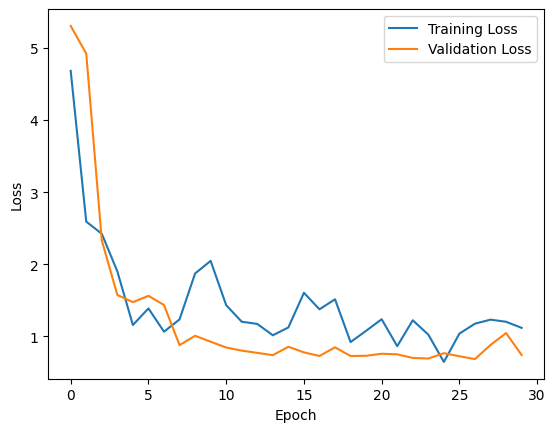

In [74]:
# Defining the final trained model
def train_final_model(features, labels, features_val, labels_val, learning_rate, batch_size):
    dataset = AudioDataset(features, labels)
    dataloader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)
    
    dataset_val = AudioDataset(features_val, labels_val)
    dataloader_val = DataLoader(dataset_val, batch_size=int(batch_size), shuffle=False)

    input_size = features.shape[1]

    model = CNN(input_size)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)  # Increased L2 regularization
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=0.00001)  # More aggressive decay
    
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)  # Increased patience

    model.train()
    num_epochs = 30
    
    training_losses = []
    validation_losses = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in dataloader:
            inputs = inputs.float()
            labels = labels.float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        training_losses.append(loss.item())
        
        # Evaluate the model
        validation_loss = evaluate_model(model, dataloader_val, criterion)
        validation_losses.append(validation_loss)
        scheduler.step(validation_loss)

        print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {validation_loss}')
        
        early_stopping(validation_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Ploting the loss curves for visualization
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model 

# Training the model with optimized parameters from tuning
optimal_params = result['params'] 
trained_model = train_final_model(features, labels, features_val, labels_val, **optimal_params)


In [21]:
test_frames = []
directory_path = '/Users/sofie/Downloads/test'

for filename in os.listdir(directory_path):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'rb') as f:
            test_frames.append((filename, pickle.load(f)))

test_features = np.array([extract_features(entry[1]) for entry in test_frames])
test_filenames = [entry[0] for entry in test_frames]

# Define the TestDataset class for testing purposes
class TestDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx]

# Creating DataLoader for test data
def create_test_dataloader(features_test, batch_size):
    test_dataset = TestDataset(features_test)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_dataloader

# Defining the valence prediction function
def predict_valence(model, test_dataloader):
    model.eval()  
    predictions = []

    with torch.no_grad():
        for inputs in test_dataloader:
            inputs = inputs.float()
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy().flatten())

    return predictions

# Defining the batch size
batch_size = 17

# Creating DataLoader for the test data
test_dataloader = create_test_dataloader(test_features, batch_size)

# Predicting valence values using the final trained model
predictions = predict_valence(trained_model, test_dataloader)

# Output predictions
for i in range(min(10, len(predictions))):  # Print the first 10 predictions for review
    print(f"{test_filenames[i]}, {predictions[i]}")

# Creating a DataFrame for the predictions
df = pd.DataFrame({'ID': test_filenames, 'Label': predictions})

# Saving the predictions to a CSV file
output_csv_path = '/Users/sofie/Downloads/DL-predictions.csv'
df.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")


13170.pkl, 3.0288608074188232
18025.pkl, 2.347562074661255
16746.pkl, 2.6691648960113525
17458.pkl, 2.832190752029419
14151.pkl, 2.4736058712005615
21101.pkl, 2.386491298675537
13819.pkl, 2.7987771034240723
14810.pkl, 2.9580748081207275
21673.pkl, 3.710451602935791
21883.pkl, 2.8105974197387695
Predictions saved to /Users/sofie/Downloads/DL-predictions.csv
